In [1]:
import numpy as np
from qiskit.providers.fake_provider import FakeManila
import qiskit.pulse as pulse

from casq.pulse_simulator import PulseSimulator
from casq.gates.gaussian_pulse_gate import GaussianPulseGate
from casq.common.plotting import plot, plot_bloch, plot_signal, LineStyle, LineType

%matplotlib inline


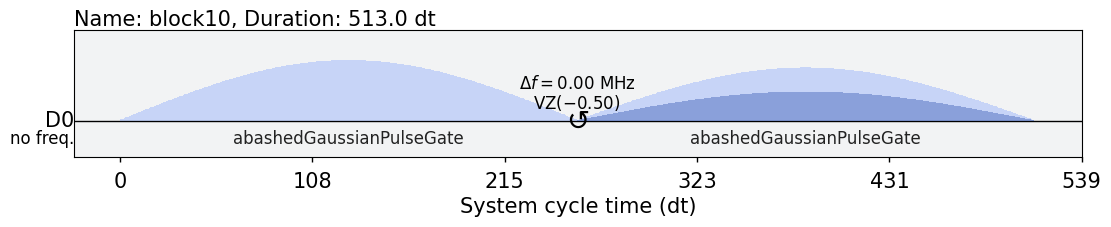

In [2]:
qubit = 0
duration = 256
sigma = 128

schedules = []

for amplitude in np.linspace(0., 1., 10):
    gpg = GaussianPulseGate(duration, amplitude, sigma)
    with pulse.build() as schedule:
        with pulse.align_sequential():
            gpg.instruction(qubit)
            pulse.shift_phase(0.5, pulse.DriveChannel(qubit))
            pulse.shift_frequency(0.1, pulse.DriveChannel(qubit))
            gpg.instruction(qubit)
            pulse.acquire(duration=1, qubit_or_channel=qubit, register=pulse.MemorySlot(qubit))

    schedules.append(schedule)

schedules[5].draw()


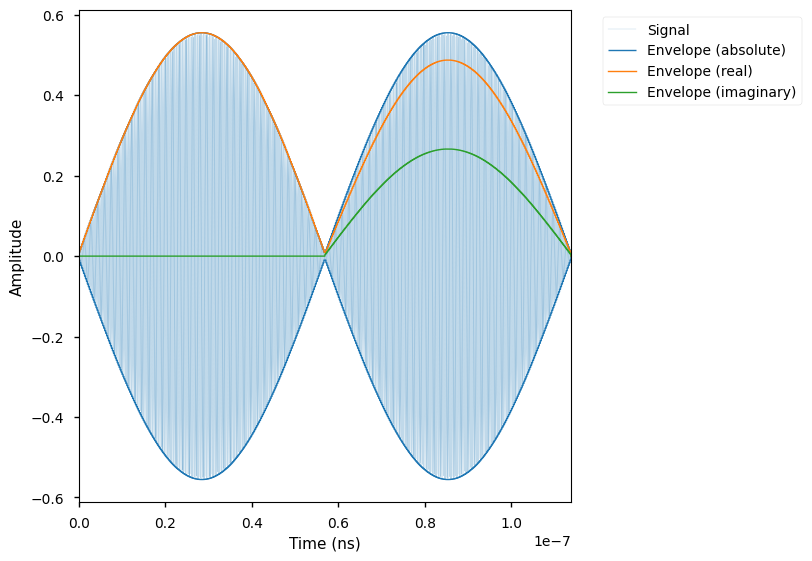

In [3]:
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.pulse.transforms import block_to_schedule

fake_backend = FakeManila()
config = fake_backend.configuration()
props = fake_backend.properties()
dt = config.dt
w = props.frequency(qubit)

fig = plot_signal(schedules[5], dt, "d0", w, 2*duration*dt)


In [4]:
simulator = PulseSimulator(FakeManila(), [0])

In [5]:
solution = simulator.run(sxp)[0]


NameError: name 'sxp' is not defined

In [ ]:
print(solution.y[-1].data)


In [ ]:
x = []
y = []
z = []
for sv in solution.y:
    xp, yp, zp = sv.data.real
    x.append(xp)
    y.append(yp)
    z.append(zp)
p0 = [sv.probabilities()[0] for sv in solution.y]
p1 = [sv.probabilities()[1] for sv in solution.y]


In [ ]:
plot(data=[
        (solution.t, x, "$\\langle X \\rangle$", None, None),
        (solution.t, y, "$\\langle Y \\rangle$", None, None),
        (solution.t, z, "$\\langle Z \\rangle$", None, None),
    ],
    title="Bloch vector vs. $t$", xtitle="$t$",
    show_legend=True
)


In [ ]:
plot_bloch(x, y, z)


In [ ]:
plot(data=[
        (solution.t, p0, "Population in |0>", LineStyle(size=3), None),
        (solution.t, p1, "Population in |1>", LineStyle(size=3), None)
    ],
    vlines=[(T, LineStyle(type=LineType.DASHED, color="black"))],
    xlim=(0, 2*T), ylim=(0, 1.05),
    xtitle="Time (ns)", ytitle="Population",
    show_legend=True
)
